# Support Vector Machines

- [1, What are SVMs?](#what-are-svms)
- [2. Primal approach - Hard-Margin SVM](#hard-margin-svm)
- [(Optional) - Deriving the margin requirement](#margin-derivation)
- [3. Primal approach - Soft-Margin SVM](#soft-margin-svm)
- [4. Solving the primal optimization problem](#solving-primal-svm)
   - [4.1 Hinge loss function](#hinge-loss)
   - [4.2 Updated objective function](#updated-objective-function)
   - [(Optional) Three parts of the objective function](#two-parts)
   - [4.3 Subgradient descent](#subgradient-descent)
   - [(Optional) Subgradient descent vs. gradient descent](#subgradient-descent-vs-gradient-descent)
- [5. Implementation of primal approach](#primal-implementation)
   - [5.1 Toy dataset](#toy-dataset)
   - [5.2 SVM class](#primal-svm-class)
   - [5.3 Training and testing an SVM](#train-test-svm)  
   - [5.4 Visualizing the decision boundary](#decision-boundary)
- [6. Dual approach](#dual-approach)
    - [6.1 Recap Lagrange multipliers](#recap-lagrange-multipliers)
    - [6.2 Recap Lagrangian](#recap-lagrangian)
    - [6.3 Dual optimization problem](#dual-optimization-problem)
- [7. Primal vs. dual approach](#primal-vs-dual)
- [8. Kernels / non-linear SMVs](#kernel-svms)
    - [8.1 What is a kernel?](#what-is-a-kernel)
    - [8.2 What are kernels good for?](#what-are-kernels-good-for)
    - [8.3 Example](#kernel-example)
    - [8.4 Can we also use kernels in the primal SVM?](#kernel-in-primal-svm)
- [9. Sources and further reading](#sources)

## Link to interactive demo

[Click here](https://mybinder.org/v2/gh/zotroneneis/machine_learning_basics/HEAD?filepath=support_vector_machines.ipynb) to run the notebook online (using Binder) without installing jupyter or downloading the code.

Sometimes, the GitHub version of the Jupyter notebook does not display the math formulas correctly. Please refer to the Binder version in case you think something might be off or missing.

I also wrote a [blog post containing the contents of the notebook](https://alpopkes.com/posts/machine_learning/support_vector_machines/).

## 1. What are support vector machines? <a class="anchor" id="what-are-svms"></a>

Support vector machines (short: SVMs) are supervised machine learning models. They are the most prominent member of the class of [*kernel methods*](https://en.wikipedia.org/wiki/Kernel_method). SVMs can be used both for classification and regression. The original SVM proposed in 1963 is a simple binary linear classifier. What does this mean?

Assume we are given a dataset $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$, where $\mathbf{x}_n \in \mathbb{R}^D$ and labels $y_n \in \{-1, +1 \}$. A linear (hard-margin) SVM separates the two classes using a ($D-1$ dimensional) hyperplane.

Special to SVMs is that they use not any hyperplane but the one that maximizes the distance between itself and the two sets of datapoints. Such a hyperplane is called *maximum-margin* hyperplane:

<img src="figures/separating_hyperplanes.png" width="800"/>

In case you have never heard the term margin: the margin describes the distance between the hyperplane and the closest examples in the dataset.

Two types of SVMs exist: primals SVMs and dual SVMs. Although most research in the past looked into dual SVMs both can be used to perform non-linear classification. Therefore, we will look at both approaches and compare them in the end.

## 2. Primal approach - Hard-margin SVM  <a class="anchor" id="hard-margin-svm"></a>

When training an SVM our goal is to find the hyperplane that maximizes the margin between the two sets of points. This hyperplane is fully defined by the points closest to the margin, which are also called *support vectors*.

The equation of a hyperplane is given by $\langle \mathbf{w}, \mathbf{x} \rangle + b = 0$, where $\langle \cdot, \cdot \rangle$ denotes the inner product and $\mathbf {w}$ is the normal vector to the hyperplane. If an example $\mathbf{x}_i$ lies on the right side of the hyperplane (that is, it has a positive label) we have $\langle \mathbf{w}, \mathbf{x}_i \rangle + b \gt 0$. If instead $\mathbf{x}_i$ lies on the left side (= negative label) we have $\langle \mathbf{w}, \mathbf{x}_i \rangle + b \lt 0$.

The support vectors lie exactly on the margin and the optimal separating hyperplane should have the same distance from all support vectors. In this sense the maximum margin hyperplane lies between two separating hyperplanes that are determined by the support vectors:

<img src="figures/delimiting_hyperplanes.png" width="450"/>

### Goal 1:
When deriving a formal equation for the maximum margin hyperplane we assume that the two delimiting hyperplanes are given by:   
$$\langle \mathbf{w}, \mathbf{x}_{+} \rangle + b = +1$$ 
$$\langle \mathbf{w}, \mathbf{x}_{-} \rangle + b = -1$$

In other words: we want our datapoints two lie at least a distance of 1 away from the decision hyperplane into both directions. To be more precise: for our positive examples (those with label $y_n = +1$) we want the following to hold: $\langle \mathbf{w}, \mathbf{x}_n \rangle + b \ge +1$.

For our negative examples (those with label $y_n = -1$) we want the opposite: $\langle \mathbf{w}, \mathbf{x}_n \rangle + b \le -1$. This can be combined into a single equation: $y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1$. This is our first goal: **We want a decision boundary that classifies our training examples correctly.**


### Goal 2:
Our second goal is to maximize the margin of this decision boundary. The margin is given by $\frac{1}{\mathbf{w}}$. If you would like to understand where this value is coming from take a look at the section "*(Optional) Deriving the margin equation*" below.

Our goal to maximize the margin can be expressed as follows:
$$ \max_{\mathbf{w}, b} \frac{1}{\Vert \mathbf{w} \Vert}$$

Instead of maximizing $\frac{1}{\Vert \mathbf{w} \Vert}$ we can instead minimize $\frac{1}{2} \Vert \mathbf{w} \Vert^2$. This simplifies the computation of the gradient.

### Combined goal
Combining goal one and goal two yields the following objective function:   
$$
\min_{\mathbf{w}, b} \frac{1}{2} \Vert \mathbf{w} \Vert^2
$$
$$
\text{subject to: } y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 \text{ for all } n = 1, ..., N
$$

In words: we want to find the values for $\mathbf{w}$ and $b$ that maximize the margin while classifying all training examples correctly. This approach is called the *hard-margin support vector machine*. "Hard" because it does not allow for violations of the margin requirement (= no points are allowed to be within the margin).

## (Optional) Deriving the margin equation <a class="anchor" id="margin-derivation"></a>

We can derive the width of the margin in several ways (see sections 12.2.1-12.2.2 of the [Mathematics for Machine Learning book](https://mml-book.com)). Personally, I found the explanation of [this MIT lecture on SVMs](https://www.youtube.com/watch?v=_PwhiWxHK8o) easiest to understand.

The derivation of the margin is based on the assumptions that we have already noted above:
$$\langle \mathbf{w}, \mathbf{x}_{+} \rangle + b = +1$$ 
$$\langle \mathbf{w}, \mathbf{x}_{-} \rangle + b = -1$$

Including the label of each example we can rewrite this as 
$$y_i (\langle \mathbf{w}, \mathbf{x}_{i} \rangle + b) -1 = 0$$

Let's say we have a positive example $\mathbf{x}_{+}$ that lies on the right delimiting hyperplane and a negative example $\mathbf{x}_{-}$ that lies on the left delimiting hyperplane. The distance between these two vectors is given by ($\mathbf{x}_{+} - \mathbf{x}_{-})$. We want to compute the orthogonal projection of the vector onto the line that is perpendicular to the decision hyperplane. This would give us the width between the two delimiting hyperplanes. We can compute this by multiplying the vector ($\mathbf{x}_{+} - \mathbf{x}_{-})$ with a vector that is perpendicular to the hyperplane. We know that the vector $\mathbf{w}$ is perpendicular to the decision hyperplane. So we can compute the margin by multiplying $(\mathbf{x}_{+} - \mathbf{x}_{-})$ with the vector $\mathbf{w}$ where the latter is divided by the scale $||\mathbf{w}||$ to make it a unit vector.

<img src="figures/maximum_margin_derivation.png" width="500"/>

$$
\begin{align*}
\text{width} &= (\mathbf{x}_{+} - \mathbf{x}_{-}) \cdot \frac{\mathbf{w}}{||\mathbf{w}||} \\
&= \frac{\mathbf{x}_{+} \cdot \mathbf{w}}{||\mathbf{w}||} - \frac{\mathbf{x}_{-} \cdot \mathbf{w}}{||\mathbf{w}||}
\end{align*}
$$

For the positive example $\mathbf{x}_{+}$ we have $y_+ = +1$ and therefore $(\langle \mathbf{w}, \mathbf{x}_{+} \rangle = 1 - b$. For the negative example $\mathbf{x}_{-}$ we have $y_- = -1$ and therefore $- (\langle \mathbf{w}, \mathbf{x}_{-} \rangle) = 1 + b$:

$$
\begin{align*}
\text{width} &= (\mathbf{x}_{+} - \mathbf{x}_{-}) \cdot \frac{\mathbf{w}}{||\mathbf{w}||} \\
&= \frac{\mathbf{x}_{+} \cdot \mathbf{w}}{||\mathbf{w}||} - \frac{\mathbf{x}_{-} \cdot \mathbf{w}}{||\mathbf{w}||} \\ 
&= \frac{(1 - b) + (1 + b)}{||\mathbf{w}||}\\ 
&= \frac{2}{||\mathbf{w}||}\\ 
\end{align*}
$$

We conclude that the width between the two delimiting hyperplanes equals $\frac{2}{\mathbf{w}}$. And therefore, that the distance between the decision hyperplane and each delimiting hyperplane is $\frac{1}{\mathbf{w}}$.

##  3. Primal approach - Soft-margin SVM <a class="anchor" id="soft-margin-svm"></a>

In most real-world situations the available data is not linearly separable. Even if it is, we might prefer a solution which separates the data well while ignoring some noisy examples and outliers. This motivated an extension of the original hard-margin SVM called *soft-margin SVM*.

A soft-margin SVM allows for violations of the margin requirement (= classification errors). In other words: not all training examples need to be perfectly classified. They might fall within the margin or even lie on the wrong side of the decision hyperplane. However, such violations are not for free. We pay a cost for each violation, where the value of the cost depends on how far the example is from meeting the margin requirement.

To implement this we introduce so called *slack variables* $\xi_n$. Each training example $(\mathbf{x}_n, y_n)$ is assigned a slack variable $\xi_n \ge 0$. The slack variable allows this example to be within the margin or even on the wrong side of the decision hyperplane:

- If $\xi_n = 0$ the training example $(\mathbf{x}_n, y_n)$ lies exactly on the margin
- $0 \lt \xi_n \lt 1$ the training example lies within the margin but on the correct side of the decision hyperplane
- $\xi_n \ge 1$ the training example lies on the wrong side of the decision hyperplane
    
We extend our objective function to include the slack variables as follows:
$$ \min_{\mathbf{w}, b, \mathbf{\xi}} \frac{1}{2} \Vert \mathbf{w} \Vert^2 + C \sum_{n=1}^N \xi_n $$

$$ \text{subject to:} $$

$$ \begin{equation}
y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 - \xi_n
\end{equation}$$

$$ \xi_i \ge 0 \text{ for all } n = 1, ..., N $$

Note: the objective function is somewhat not displayed correctly within the GitHub version of the notebook. It should look as follows:

<img src="figures/primal_optimization_problem.png" width="220"/>

The parameter $C$ is a regularization term that controls the trade-off between maximizing the margin and minimizing the training error (which in turn means classifying all training examples correctly). If the value of $C$ is small, we care more about maximizing the margin than classifying all points correctly. If the value of $C$ is large, we care more about classifying all points correctly than maximizing the margin.

## 4. Solving the primal optimization problem <a class="anchor" id="solving-primal-svm"></a>

Theoretically, the primal SVM can be solved in multiple ways. The most well known way is to use the [hinge loss function](https://en.wikipedia.org/wiki/Hinge_loss) together with [subgradient descent](https://en.wikipedia.org/wiki/Subgradient_method).

### 4.1 Hinge loss function <a class="anchor" id="hinge-loss"></a>
The hinge loss function given the true target $y \in \{-1, +1\}$ and the prediction $f(\mathbf{x}) = \langle\mathbf{w}, \mathbf{x}\rangle+b$ is computed as follows:

$$\ell(t)=\max \{0,1-t\} \quad \text{where} \quad t=y \cdot f(\mathbf{x})= y \cdot \big(\langle\mathbf{w}, \mathbf{x}\rangle+b\big)$$

Let's understand the output of this loss function with a few examples:
- If a training example has label $y = -1$ and the prediction is on the correct side of the marghin (that is, $f(\mathbf{x}) \le -1$), the value of $t$ is larger or equal to $+1$. Therefore, the hinge loss will be zero ($\ell(t) = 0$)
- The same holds if a training example has label $y = 1$ and the prediction is on the correct side of the margin (that is, $f(\mathbf{x}) \ge 1$)
- If a training example ($y = 1$) is on the correct side of the decision hyperplane but lies within the margin (that is, $0 \lt f(\mathbf{x}) \lt 1$) the hinge loss will output a positive value.
- If a training example ($y = 1$) is on the wrong side of the decision hyperplane (that is, $f(\mathbf{x}) \lt 0$), the hinge loss returns an even larger value. This value increases linearly with the distance from the decision hyperplane

<img src="figures/hinge_loss.png" width="600"/>


### 4.2 Updated objective function <a class="anchor" id="updated-objective-function"></a>

Using the hinge loss we can reformulate the optimization problem of the primal soft-margin SVM. Given a dataset $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$ we would like to minimize the total loss which is now given by:

$$
\min _{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^{2} + C \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle+b\right)\right\}
$$

If you would like to understand why this is equivalent to our previous formulation of the soft-margin SVM please take a look at chapter 12.2.5 of the [Mathematics for Machine Learning book](https://mml-book.com).

### [Optional] Three parts of the objective function <a class="anchor" id="two-parts"></a>

Our objective function can be divided into three distinct parts:

Part 1: $\frac{1}{2}\|\mathbf{w}\|^{2}$

This part is also called the *regularization term*. It expresses a preference for solutions that separate the datapoints well, thereby maximizing the margin. In theory, we could replace this term by a different regularization term that expresses a different preference.

Part 2: $\sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle+b\right)\right\}$

This part is also called the *empirical loss*. In our case it's the hinge loss which penalizes solutions that make mistakes when classifying the training examples. In theory, this term could be replaced with another loss function that expresses a different preference.

Part 3: The hyperparameter $C$ that controls the tradeoff between a large margin and a small hinge loss.

### 4.3 Sub-gradient descent <a class="anchor" id="subgradient-descent"></a>

The hinge loss function is not differentiable (namely at the point $t=1$). Therefore, we cannot compute the gradient right away. However, we can use a method called [subgradient descent](https://en.wikipedia.org/wiki/Subgradient_method) to solve our optimization problem. To simplify the derivation we will adapt two things:
1. We assume that the bias $b$ is contained in our weight vector as the first entry $w_0$, that is $\mathbf{w} = [b, w_1, ..., w_D]$
2. We divide the hinge loss by the number of samples

Our cost function is then given by 
$$
J(\mathbf{w}) = \frac{1}{2}\|\mathbf{w}\|^{2} + C \frac{1}{N} \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}
$$

We will reformulate this to simplify computing the gradient:
$$
J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^{N} \Big[ \frac{1}{2}\|\mathbf{w}\|^{2} + C \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}\Big]
$$


The gradient is given by:
$$
\nabla_{w} J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N \left\{\begin{array}{ll}
\mathbf{w} & \text{if} \max \left(0,1-y_{n} \left(\langle \mathbf{w}, \mathbf{x}_{n} \rangle \right)\right)=0 \\
\mathbf{w}-C  y_{n} \mathbf{x}_{n} & \text { otherwise }
\end{array}\right.
$$

With this formula we can apply stochastic gradient descent to solve the optimization problem.

### [Optional] Difference subgradient descent and gradient descent <a class="anchor" id="subgradient-descent=vs-gradient-descent"></a>

The subgradient method allows us to minimize a non-differentiable convex function. Although looking similar to gradient descent the method has several important differences.

#### What is a subgradient?

A subgradient can be described as a generalization of gradients to non-differentiable functions. Informally, a sub-tangent at a point is any line that lies below the function at the point. The subgradient is the slope of this line. Formally, the subgradient of a convex function $f$ at $w_0$ is defined as all vectors $g$ such that for any other point $w$

$$ f(w) - f(w_0) \ge g \cdot (w - w_0) $$

If $f$ is differentiable at $w_0$, the subgradient contains only one vector which equals the gradient $\nabla f(w_0)$. If, however, $f$ is not differentiable, there may be several values for $g$ that satisfy this inequality. This is illustrated in the figure below.

<img src="figures/gradient_vs_subgradient.png" width="900"/>

#### Subgradient method

To minimize the objective function $f$ the subgradient method uses the following update formula for iteration $k+1$:

$$ w^{(k+1)} = w^{(k)} - \alpha_k g^{(k)}$$ 

Where $g^{(k)}$ is *any* subgradient of $f$ at $w^{(k)}$ and $\alpha_k$ is the $k$-th step size. Thus, at each iteration, we make a step into the direction of the negative subgradient. When $f$ is differentiable, $g^{(k)}$ equals the gradient $\nabla f(x^{(k)})$ and the method reduces to the standard gradient descent method.

More details on the subgradient method can be found [here](https://web.stanford.edu/class/ee392o/subgrad_method.pdf).

## 5. Implementation primal approach <a class="anchor" id="primal-implementation"></a>

### 5.1 Toy dataset <a class="anchor" id="toy-dataset"></a>
To implement what we have learned about primal SVMs we first have to generate a dataset. In the cell below we create a simple dataset with two features and labels +1 and -1. We further split the dataset into a test and train set.

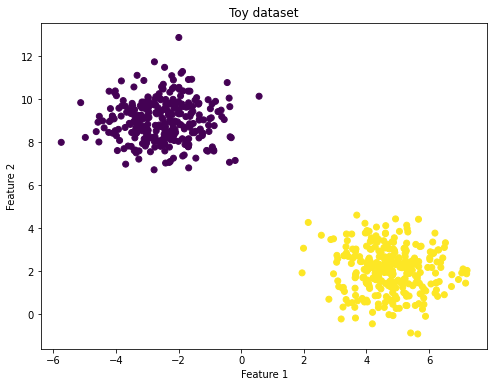

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_features, data_targets = make_blobs(n_samples=600, centers=2, n_features=2, random_state=42)

# The function outputs targets 0 and 1 so we need to convert targets 0 to -1
transformed_data_targets = [-1 if t == 0 else +1 for t in data_targets]
        
# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data_features[:, 0], data_features[:, 1], c = transformed_data_targets)
plt.title("Toy dataset")
plt.ylabel("Feature 2")
plt.xlabel("Feature 1")
plt.show()

# Split data into training and test set
features_train, features_test, labels_train, labels_test = train_test_split(data_features, 
                                                                              transformed_data_targets, 
                                                                              test_size = 0.3)

### 5.2 SVM class definition <a class="anchor" id="primal-svm-class"></a>

Next, we would like to implement an SVM class. We will use the knowledge we already acquired:

1. Our objective function using the hinge loss function is given by: 
$$
J(\mathbf{w}) = \frac{1}{2}\|\mathbf{w}\|^{2} + C \frac{1}{N} \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}
$$
2. We can minimize this function by computing the gradient: 
$$
\nabla_{w} J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N \left\{\begin{array}{ll}
\mathbf{w} & \text{if} \max \left(0,1-y_{n} \left(\langle \mathbf{w}, \mathbf{x}_{n} \rangle \right)\right)=0 \\
\mathbf{w}-C  y_{n} \mathbf{x}_{n} & \text { otherwise }
\end{array}\right.
$$
3. Given the gradient we use stochastic gradient descent to train our model
4. After training our model we can make predictions using the [sign function](https://en.wikipedia.org/wiki/Sign_function)

As mentioned previously, we will assume that the bias $b$ is contained in our weight vector as the first entry $w_0$, that is $\mathbf{w} = [b, w_1, ..., w_D] = \mathbf{w} = [w_0, w_1, ..., w_D]$.

In [2]:
import numpy as np
from sklearn.utils import shuffle

class LinearSVM:
    
    def __init__(self, regularization_param):
        """
        Initialize the model by setting the regularization parameter 
        and a boolean variable for our trained weights.
        """
        self.regularization_param = regularization_param
        self.trained_weights = None
    
    def add_bias_term(self, features):
        """
        Add intercept 1 to each training example for bias b
        """
        n_samples = features.shape[0]
        ones = np.ones((n_samples, 1))
        return np.concatenate((ones, features), axis=1)
    
    def compute_cost(self, weights, features, labels) -> float:
        """
        Compute the value of the cost function
        """
        n_samples = features.shape[0]
        
        # Compute hinge loss 
        predictions = np.dot(features, weights).flatten()
        distances = 1 - labels * predictions
        hinge_losses = np.maximum(0, distances)

        # Compute sum of the individual hinge losses
        sum_hinge_loss = np.sum(hinge_losses) / n_samples

        # Compute entire cost
        cost = (1 / 2) * np.dot(weights.T, weights) + self.regularization_param * sum_hinge_loss
        
        return float(cost)
    
    def compute_gradient(self, weights, features, labels) -> np.ndarray:
        """
        Compute the gradient, needed for training
        """
        predictions = np.dot(features, weights)
        distances = 1 - labels * predictions
        n_samples, n_feat = features.shape
        sub_gradients = np.zeros((1, n_feat))

        for idx, dist in enumerate(distances):
            if max(0, dist) == 0:
                sub_gradients += weights.T
            else:
                sub_grad = weights.T - (self.regularization_param * features[idx] * labels[idx])
                sub_gradients += sub_grad
                            
        # Sum up and divide by the number of samples
        avg_gradient = sum(sub_gradients) / len(labels)

        return avg_gradient
    
    def train(self, train_features, train_labels, n_epochs, learning_rate=0.01, batch_size=1):
        """
        Train the model with stochastic gradient descent using the
        specified number of epochs, learning rate and batch size.
        """
        # Add bias term to features
        train_features = self.add_bias_term(train_features)
        
        # Initalize weight vector
        n_samples, n_feat = train_features.shape
        weights = np.zeros(n_feat)[:, np.newaxis]
        
        # Train the model for a certain number of epochs
        for epoch in range(n_epochs):
            features, labels = shuffle(train_features, train_labels)
            features, labels = train_features, train_labels
            start, end = 0, batch_size
            while end <= len(labels): # Training loop over the dataset
                batch = features[start:end]
                batch_labels = labels[start:end]
                
                grad = self.compute_gradient(weights, batch, batch_labels)
                update = (learning_rate * grad)[:, np.newaxis]
                weights = weights - update
                start, end = end, end + batch_size
                
            current_cost = self.compute_cost(weights, features, labels)
            print(f"Epoch {epoch + 1}, cost: {current_cost}")
                
        # Set the trained weights to allow making predictions
        self.trained_weights = weights

    def predict(self, test_features) -> np.ndarray:
        """
        Predict labels for new test features.
        Raises ValueError if model has not been trained yet.
        """
        test_features = self.add_bias_term(test_features)
        if self.trained_weights is None:
            raise ValueError("You haven't trained the SVM yet!")
            
        predicted_labels = []
        n_samples = test_features.shape[0]
        for idx in range(n_samples):
            prediction = np.sign(np.dot(self.trained_weights.T, test_features[idx]))
            predicted_labels.append(prediction)
            
        return np.array(predicted_labels)

In [3]:
# Compute some values to make sure the cost is computed correctly
# I calculated the values for this example by hand first
svm = LinearSVM(regularization_param=1)
weights = np.array([1, 2])[:, np.newaxis]
features = np.array([[0.5], [2.5]])
new_features = svm.add_bias_term(features)

labels = np.array([-1, +1])
assert svm.compute_cost(weights, new_features, labels) == 4.
gradient = svm.compute_gradient(weights, new_features, labels[:, np.newaxis])

### 5.3 Training and testing an SVM <a class="anchor" id="train-test-svm"></a>

After defining our SVM class we can train a model and test it on unseen examples.

In [4]:
# Initialize a new SVM and train it on the given toy dataset
regularization_param = 100
lr = 0.000001
svm = LinearSVM(regularization_param)
trained_weights = svm.train(features_train, labels_train, n_epochs=10, learning_rate=lr)

Epoch 1, cost: 27.249462152357992
Epoch 2, cost: 7.348722759212155
Epoch 3, cost: 3.3972581191442885
Epoch 4, cost: 2.27870883462286
Epoch 5, cost: 1.8875111235175854
Epoch 6, cost: 1.6020090021589712
Epoch 7, cost: 1.413202164641454
Epoch 8, cost: 1.2452165334256207
Epoch 9, cost: 1.1141080363838292
Epoch 10, cost: 1.0118493571787424


In [5]:
# Predict lables for unknown test samples
from sklearn.metrics import accuracy_score, recall_score, precision_score

predicted_labels = svm.predict(features_test)
predicted_labels = predicted_labels.flatten()

print("Accuracy on test dataset: {}".format(accuracy_score(labels_test, predicted_labels)))
print("Recall on test dataset: {}".format(recall_score(labels_test, predicted_labels)))
print("Precision on test dataset: {}".format(precision_score(labels_test, predicted_labels)))    

Accuracy on test dataset: 1.0
Recall on test dataset: 1.0
Precision on test dataset: 1.0


### 5.4 Visualizing the decision boundary <a class="anchor" id="decision-boundary"></a>

Given our trained model we can visualize the decision boundary, as done below.

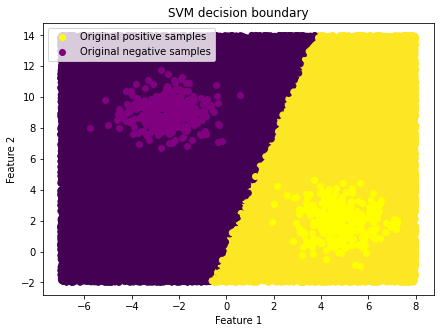

In [12]:
import numpy as np

# Create dataset for visualization
size=40000
feat_1 = np.random.uniform(low=-7, high=8, size=size)
feat_2 = np.random.uniform(low=-2, high=14, size=size)
features_vis = np.column_stack((feat_1, feat_2))

labels_vis = svm.predict(features_vis)

# Plot the decision boundary
plt.figure(figsize=(7, 5))
plt.scatter(features_vis[:, 0], features_vis[:, 1], c = labels_vis)
# Plot original dataset
positive_samples = [idx for idx in range(len(transformed_data_targets)) if transformed_data_targets[idx] == +1]
negative_samples = [idx for idx in range(len(transformed_data_targets)) if transformed_data_targets[idx] == -1]
plt.scatter(data_features[positive_samples, 0],
            data_features[positive_samples, 1],
            c="yellow", label="Original positive samples")
plt.scatter(data_features[negative_samples, 0],
            data_features[negative_samples, 1],
            c="purple", label="Original negative samples")
plt.title("SVM decision boundary")
plt.ylabel("Feature 2")
plt.xlabel("Feature 1")
plt.legend(loc=2)
plt.show()

## 6. Dual approach <a class="anchor" id="dual-approach"></a>

In the previous sections we took a detailed look at the primal SVM. To solve a primal SVM, we need to find the best values for the weights and bias. Recall that our input examples $\mathbf{x} \in \mathbb{R}^D$ have $D$ features. Consequently, our weights $\mathbf{w}$ have $D$ features, too. This can become problematic if the number of features $D$ is large.

That's where the second way of formalizing SVMs (called *dual approach*) comes in handy. The optimization problem of the dual approach is independent of the number of features. Instead, the number of parameters increases with the number of examples in the training set. 

The dual approach uses the method of Lagrange multipliers. Lagrange multipliers allow us to find the minimum or maximum of a function if there are one or more constraints on the input values we are allowed to used.

If you never heard of Lagrange multipliers I can recommend the [blog posts](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint) and [video tutorials](https://www.youtube.com/watch?v=yuqB-d5MjZA&list=PLCg2-CTYVrQvNGLbd-FN70UxWZSeKP4wV&index=1) on the topic from Khan Academy.

### 6.1 Recap Lagrange multipliers <a class="anchor" id="recap-lagrange-multipliers"></a>

Lagrange multipliers allow us to solve constrained optimization problems. Let's say we want to maximize the function $f(x, y) = 2x + y$ under the constraint that our values of $x$ and $y$ satisfy the following equation: $g(x, y) := x^2 + y^2 = 1$. This constraint equation describes a circle of radius 1. 

The key insight behind the solution to this problem is that we need to find those values for $x$ and $y$ where the gradients of $f$ and $g$ are aligned. This can be expressed using a Lagrange multiplier (typically $\lambda$):

We want to find those values $x_m, y_m$ where $\nabla f(x_m, y_m) = \lambda \nabla g(x_m, y_m)$.

In our example the gradient vectors look as follows:
$$ \nabla f(x, y)=\left[\begin{array}{c}
\frac{\partial}{\partial x}(2 x+y) \\
\frac{\partial}{\partial y}(2 x+y)
\end{array}\right]=\left[\begin{array}{c}
2 \\ 1
\end{array}\right]$$
 
$$ \nabla g(x, y)=\left[\begin{array}{c}
\frac{\partial}{\partial x}\left(x^{2}+y^{2}-1\right) \\
\frac{\partial}{\partial y}\left(x^{2}+y^{2}-1\right)
\end{array}\right]=\left[\begin{array}{c}
2 x \\ 2 y
\end{array}\right]$$

Therefore, the tangency condition results in 
$$ \left[\begin{array}{l}
2 \\ 1
\end{array}\right]=\lambda \left[\begin{array}{l}
2 x_{m} \\ 2 y_{m}
\end{array}\right] $$

We can rewrite the vector form into individual equations that can be solved by hand:
- $2 = \lambda 2 x_m $    
- $1 = \lambda 2 y_m $    
- $x_m^2 + y_m^2 = 1 $

Solving the equations yields 
$$ \begin{aligned}
\left(x_{0}, y_{0}\right) &=\left(\frac{1}{\lambda_{0}}, \frac{1}{2 \lambda_{0}}\right) \\
&=\left(\frac{2}{\sqrt{5}}, \frac{1}{\sqrt{5}}\right) \quad \text { or } \quad\left(\frac{-2}{\sqrt{5}}, \frac{-1}{\sqrt{5}}\right)
\end{aligned} $$

where the first point denotes a maximum (what we wanted to find) and the second a minimum. This solves our constrained optimization problem. For more details and a full solution look at [this Khan academy post](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint).

### 6.2 Recap Lagrangian  <a class="anchor" id="recap-lagrangian"></a>

The Lagrangian is a way to repackage the individual conditions of our constrained optimization problem into a single equation. In the example above we wanted to optimize some function $f(x, y)$ under the constraint that the inputs $x$ and $y$ satisfy the equation $g(x, y) = x^2 + y^2 = c$. In our case the constant $c$ was given by 1. We know that the solution is given by those points where the gradients of $f$ and $g$ align. The Lagrangian function puts all of this into a single equation:

$$ \mathcal{L}(x, y, \lambda)=f(x, y)-\lambda(g(x, y)-c) $$

When computing the partial derivatives of $\mathcal{L}$ with respect to $x, y$ and $\lambda$ and setting them to zero, we will find that they correspond exactly to the three constraints we looked at earlier. This can be summarized by simply setting the gradient of $\mathcal{L}$ equal to the zero vector: $\nabla \mathcal{L} = \mathbf{0}$. The compact Lagrangian form is often used when solving constrained optimization problem with computers because it summarizes the elaborate problem with multiple constraints into a single equation. For more details and a full solution look at [this Khan academy post](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint).

### 6.3 Dual optimization problem   <a class="anchor" id="dual-optimization-problem"></a>
For the primal soft-margin SVM we considered the following optimization problem: 
$$ \min_{\mathbf{w}, b, \mathbf{\xi}} \frac{1}{2} \Vert \mathbf{w} \Vert^2 + C \sum_{n=1}^N \xi_n $$

$$ \text{subject to:} $$

$$ y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 - \xi_n $$

$$ \xi_i \ge 0 \text{ for all } n = 1, ..., N $$

Note: the optimization problem is somewhat not displayed correctly within the GitHub version of the notebook. It should look as follows:

<img src="figures/primal_optimization_problem.png" width="220"/>

To derive the corresponding Lagrangian we will introduce two Lagrange multipliers: $\alpha_n$ for the first constraint (that all examples are classified correctly) and $\lambda_n$ for the second constraint (non-negativity of the slack variables). The Lagrangian is then given by:

$$
\begin{aligned}
\mathfrak{L}(\boldsymbol{w}, b, \xi, \alpha, \gamma)=& \frac{1}{2}\|\boldsymbol{w}\|^{2}+C \sum_{n=1}^{N} \xi_{n} \\
& \underbrace{-\sum_{n=1}^{N} \alpha_{n}\left(y_{n}\left(\left\langle\boldsymbol{w}, \boldsymbol{x}_{n}\right\rangle+b\right)-1+\xi_{n}\right)}_{\text{first constraint}} \underbrace{-\sum_{n=1}^{N} \gamma_{n} \xi_{n}}_{\text{second constraint}}
\end{aligned}
$$

Next, we have to compute the partial derivatives of the Lagrangian with respect to the variables $\mathbf{w}, b$ and $\xi$: $\frac{\partial \mathfrak{L}}{\partial \mathbf{w}}, \frac{\partial \mathfrak{L}}{\partial b}, \frac{\partial \mathfrak{L}}{\partial \xi}$. When setting the first partial derivative to zero we obtain an important interim result: 
$$ \mathbf{w} = \sum_{n=1}^N \alpha_n y_n \mathbf{x}_n $$

This equation states the the optimal solution for the weight vector is given by a linear combination of our training examples. After setting the other partial derivatives to zero, using the result and simplifying the equations we end up with the following optimization problem (for details see section 12.3.1 of the [Mathematics for Machine Learning book](https://mml-book.com)):

$$\min _{\boldsymbol{\alpha}} \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} y_{i} y_{j} \alpha_{i} \alpha_{j}\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle-\sum_{i=1}^{N} \alpha_{i}$$
$$ \text{subject to:} $$
$$\sum_{i=1}^{N} y_{i} \alpha_{i}=0$$
$$0 \le \alpha_{i} \le C \text{ for all } i=1, \ldots, N$$

Note: the optimization problem is somewhat not displayed correctly within the GitHub version of the notebook. It should look as follows:

<img src="figures/dual_optimization_problem.png" width="270"/>

This constrained quadratic optimization problem can be solved very efficiently, for example with quadratic programming techniques. One popular library for solving dual SVMs is [libsvm](https://github.com/cjlin1/libsvm) which makes use of a decomposition method to solve the problem (see [this paper](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf) for more details). However, several other approaches exist.

## 7. Primal vs. dual approach <a class="anchor" id="primal-vs-dual"></a>

Most SVM research in the last decade has been about the dual formulation. Why this is the case is not clear. Both approaches have advantages and disadvantages. In the paper ["Training a Support Vector Machine in the Primal"](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.129.3368&rep=rep1&type=pdf) Chapelle et al. mention the following hypothesis: 

> We believe that it is because SVMs were first introduced in their hard margin formulation (Boser et al., 1992), for which a dual optimization (because of the constraints) seems more natural. In general, however, soft margin SVMs should be preferred, even if the training data are separable: the decision boundary is more robust because more training points are taken into account (Chapelle et al., 2000). We do not pretend that primal optimization is better in general; our main motivation wasto point out that primal and dual are two sides of the same coin and that there is no reason to look always at the same side.

## 8. Kernels / non-linear SVM <a class="anchor" id="kernel-svms"></a>

### 8.1 What is a kernel? <a class="anchor" id="what-is-a-kernel"></a>
If you take another look at the optimization equation of dual SVMs you will notice that it computes the inner product $\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle$ between all datapoints $\mathbf{x}_{i}, \mathbf{x}_{j}$. A kernel is a way to compute this inner product implicitely in some (potentially very high dimensional) feature space. To be more precise: assume we have some mapping function $\varphi$ which maps an $n$ dimensional input vector to an $m$ dimensional output vector: $\varphi \, : \, \mathbb R^n \to \mathbb R^m$. Given this mapping function we can compute the dot product of two vectors $\mathbf x$ and $\mathbf y$ in this space as follows: $\varphi(\mathbf x)^T \varphi(\mathbf y)$.

A kernel is a function $k$ that gives the same result as this dot product: $k(\mathbf x, \mathbf y) = \varphi(\mathbf x)^T \varphi(\mathbf y)$. In other words: the kernel function is equivalent to the dot product of the mapping function.

### 8.2 What are kernels good for? <a class="anchor" id="what-are-kernels-good-for"></a>

Until now (apart from the soft-margin SVM) our SVMs, both primal and dual, are only able to classify data that is [linearly separable](https://en.wikipedia.org/wiki/Linear_separability). However, most datasets in practice won't be of this form. We need a way to classify data that is **not** linearly separable. This is where the so called **kernel trick** comes into play.

Because the objective function of the dual SVM contains inner products only between datapoints $\mathbf{x}_i, \mathbf{x}_j$, we can easily replace this inner product (that is, $\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle$ ) with some mapping function $\varphi(\mathbf{x}_i)^T \varphi(\mathbf{x}_j)$. This mapping function can be non-linear, allowing us to compute an SVM that is non-linear with respect to the input examples. The mapping function takes our input data (which is not linearly separable) and transforms it into some higher-dimensional space where it becomes linearly separable. This is illustrated in the figure below.

<img src="figures/feature_mapping_illustration.png" width="700"/>

In theory, we could use any mapping function we like. In practice, however, computing inner products is expensive. Therefore, we use mapping functions that have a corresponding kernel function. This will allow us to map the datapoints into a higher dimensional space without ever explicitely computing the (expensive) inner products.

Let's take a look at an example. 

### 8.3 Example <a class="anchor" id="kernel-example"></a>
Note: this example was taken from [this StackExchange post](https://stats.stackexchange.com/posts/153134).

We can create a simple polynomial kernel as follows: $k(\mathbf{x}, \mathbf{y}) = (1 + \mathbf x^T \mathbf y)^2$ with $\mathbf x, \mathbf y \in \mathbb R^2$. The kernel does not seem to correspond to any mapping function $\varphi$, it's just a function that returns a real number. Our input vectors $\mathbf{x}, \mathbf{y}$ are 2-dimensional: $\mathbf x = (x_1, x_2)$ and $\mathbf y = (y_1, y_2)$. With this knowledge we can expand the kernel computation:

$\begin{align*}
k(\mathbf x, \mathbf y) & = (1 + \mathbf x^T \mathbf y)^2 \\
&= (1 + x_1 \, y_1  + x_2 \, y_2)^2 \\
 & = 1 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2 x_1 y_1 + 2 x_2 y_2 + 2 x_1 x_2 y_1 y_2
\end{align*}$

Note that this is nothing else but a dot product between two vectors $(1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$ and $(1, y_1^2, y_2^2, \sqrt{2} y_1, \sqrt{2} y_2, \sqrt{2} y_1 y_2)$. This can be expressed with the following mapping function: 
$$\varphi(\mathbf x) = \varphi(x_1, x_2) = (1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$$

So the kernel $k(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2 = \varphi(\mathbf x)^T \varphi(\mathbf y)$ computes a dot product in 6-dimensional space without explicitly visiting this space. The generalization from an inner product to a kernel function is known as the **kernel trick**.

Several popular kernel functions exist. Popular ones are, for example, the [polyomial kernel](https://en.wikipedia.org/wiki/Polynomial_kernel) or [RBF kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).

### 8.4 Can we also use kernels in the primal SVM? <a class="anchor" id="kernel-in-primal-svm"></a>

Yes, the kernel trick can be applied to primal SVM's, too. It's not as straightforward as with dual SVMs but still possible. Consider [this paper by Chapelle et al.](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.129.3368&rep=rep1&type=pdf) as an example.

### 8.5 How do I choose the right kernel for my problem? <a class="anchor" id="choosing-the-right-kernel"></a>

The problem of choosing the right kernel has been answered in [this StackExchange post](
https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm). 

Summary:
- Without expert knowledge, the Radial Basis Function kernel makes a good default kernel (in case you need a non-linear model)
- The choice of the kernel and parameters can be automated by optimising a cross-validation based model selection
- Choosing the kernel and parameters automatically is tricky, as it is very easy to overfit the model selection criterion

## 9. Sources and further reading <a class="anchor" id="sources"></a>

The basis for this notebook is chapter 12 of the book [Mathematics for Machine Learning](https://mml-book.github.io/). I can highly recommend to read through the entire chapter to get a deeper understanding of support vector machines.

Another source I liked very much is [this MIT lecture on SVMs](https://www.youtube.com/watch?v=_PwhiWxHK8o).